# Benchmarking

In [1]:
%load_ext autoreload
%autoreload 2

import time

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
import torch

from htc.benchmarking.settings_bench import settings_bench
from htc.models.common.torch_helpers import scaled_stack
from htc.settings import settings
from htc.utils.helper_functions import load_util_log
from htc.utils.visualization import add_std_fill

pio.kaleido.scope.mathjax = None

## Settings

In [2]:
warmup = 2  # n epochs in the beginning which should be ignored
window = 5  # smoothing of the utilization values
sorting = ["original", "blosc", "fp16", "gpu-aug", "ring-buffer"]

## Data loading

In [3]:
rows = []
for run_dir in sorted((settings.training_dir / "image").glob(f"{settings_bench.networks_timestamp}*")):
    loading_strategy, repetition, speed = run_dir.name[20:].split("_")[1:]

    df_timings = pd.read_feather(run_dir / "fold_all" / "timings.feather")
    df_timings = df_timings[df_timings.epoch_index >= warmup]

    util = load_util_log(run_dir / "fold_all")["raw_data"]
    util_gpu = np.array(util["gpus_load"]).squeeze(axis=-1)
    util_time = np.array(util["time"])
    if len(util_gpu) != len(util_time):
        settings.log.warning(
            f"Time and GPU util vector do not match:\n{loading_strategy = }\n{repetition = }\n{speed = }"
        )

    # Select the GPU util for the time of the epoch
    epoch_utils_agg = []
    epoch_utils = []
    for i, row in df_timings.iterrows():
        assert len(util_time[util_time < row["start_time"]]) > 0, "Missing util values in the beginning"
        if len(util_time[util_time > row["end_time"]]) == 0:
            train_end_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(row["end_time"]))
            log_end_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(util_time.max()))

            settings.log.warning(
                "Some util values are missing in the end (epoch is not"
                f" used):\n{loading_strategy = }\n{repetition = }\n{speed = }\n{row.epoch_index = }\n{train_end_time = }\n{log_end_time = }"
            )
        else:
            util_epoch = util_gpu[(util_time >= row["start_time"]) & (util_time <= row["end_time"])]
            epoch_utils_agg.append(np.mean(util_epoch))
            epoch_utils.append(np.convolve(util_epoch, np.ones(window) / window, mode="valid"))

    # Bring all util values per epoch to the same length
    epoch_utils = scaled_stack([torch.from_numpy(x) for x in epoch_utils]).numpy()

    rows.append({
        "loading_strategy": loading_strategy,
        "repetition": repetition,
        "speed": speed,
        "epoch_mean": df_timings.time.mean(),
        "gpu_util": np.mean(epoch_utils_agg),
        "epoch_utils": np.mean(epoch_utils, axis=0),
    })

df = pd.DataFrame(rows)
df = df.sort_values(by="epoch_mean", ascending=False)
df

,loading_strategy,repetition,speed,epoch_mean,gpu_util,epoch_utils
22,original,2,1000mb,93.163944,0.229038,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
20,original,1,1000mb,92.624465,0.232691,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
18,original,0,1000mb,92.356349,0.232488,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,blosc,1,1000mb,73.023058,0.297386,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,blosc,2,1000mb,72.986728,0.294716,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
0,blosc,0,1000mb,72.153848,0.301311,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
23,original,2,unlimited,59.094055,0.363104,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
21,original,1,unlimited,58.470558,0.368361,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
19,original,0,unlimited,58.037800,0.375988,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,blosc,0,unlimited,55.893936,0.384111,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## Benchmark

[WARNING][py.warnings] /tmp/ipykernel_395990/778708647.py:3: FutureWarning:                              warnings.py:109
                                                                                                                        
The provided callable <function mean at 0x7f2ce0120ea0> is currently using SeriesGroupBy.mean. In a                     
future version of pandas, the provided callable will be used directly. To keep current behavior pass the                
string "mean" instead.                                                                                                  
                                                                                                                        
                                                                                                                        

[WARNING][py.warnings] /tmp/ipykernel_395990/778708647.py:3: FutureWarning:                              warnings.py:109
                                                                                                                        
The provided callable <function std at 0x7f2ce0120fe0> is currently using SeriesGroupBy.std. In a future                
version of pandas, the provided callable will be used directly. To keep current behavior pass the string                
"std" instead.                                                                                                          
                                                                                                                        
                                                                                                                        

[INFO][htc] The environment variable PATH_HTC_RESULTS_BENCH is not set. Files for the benchmarking  settings_bench.py:37
project will be written to /mnt/ssd_8tb/htc/results_benchmarking                                                        

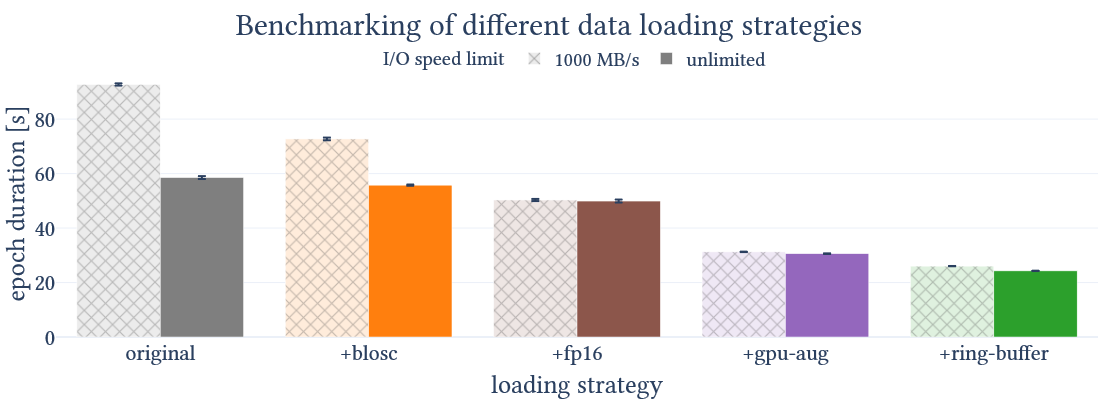

In [4]:
fig = go.Figure()

df_bar = df.groupby(["loading_strategy", "speed"], as_index=False).agg(
    epoch_mean=pd.NamedAgg(column="epoch_mean", aggfunc=np.mean),
    epoch_std=pd.NamedAgg(column="epoch_mean", aggfunc=np.std),
    gpu_util_mean=pd.NamedAgg(column="gpu_util", aggfunc=np.mean),
    epoch_utils_mean=pd.NamedAgg(
        column="epoch_utils", aggfunc=lambda x: np.mean(scaled_stack([torch.from_numpy(t) for t in x]).numpy(), axis=0)
    ),
    epoch_utils_std=pd.NamedAgg(
        column="epoch_utils", aggfunc=lambda x: np.std(scaled_stack([torch.from_numpy(t) for t in x]).numpy(), axis=0)
    ),
)
df_bar["loading_strategy"] = df_bar["loading_strategy"].astype("category")
df_bar["loading_strategy"] = df_bar["loading_strategy"].cat.set_categories(sorting)
df_bar.sort_values("loading_strategy", inplace=True, ignore_index=True)

for speed in df_bar["speed"].unique():
    df_speed = df_bar.query("speed == @speed")
    colors = settings_bench.colors_dark if speed == "unlimited" else settings_bench.colors_light
    additional = {}
    if speed != "unlimited":
        additional["marker_pattern_shape"] = "x"
        additional["marker_pattern_fgcolor"] = "black"
        additional["marker_pattern_fgopacity"] = 0.3

    speed_name = speed.replace("mb", " MB/s")
    fig.add_trace(
        go.Bar(
            name=speed_name,
            x=["+" + l if l != "original" else l for l in df_speed.loading_strategy],
            y=df_speed.epoch_mean,
            error_y=dict(type="data", array=df_speed.epoch_std),
            marker_color=[colors[l] for l in df_speed.loading_strategy],
            **additional,
        )
    )

fig.update_yaxes(title="epoch duration [s]")
fig.update_xaxes(title="loading strategy")
fig.update_layout(template="plotly_white", height=400, width=1000, margin=dict(l=0, r=0, t=70, b=0))
fig.update_layout(font_family="Libertinus Serif", font_size=22)
fig.update_layout(
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=0.97,
        xanchor="center",
        x=0.5,
        font=dict(size=20),
        title="I/O speed limit",
        title_font_size=20,
    )
)
fig.update_layout(title_x=0.5, title_text="Benchmarking of different data loading strategies")

fig.write_image(settings_bench.paper_dir / "benchmarking_loading_strategies.pdf")
fig.write_image(settings_bench.paper_dir / "benchmarking_loading_strategies.svg")
fig

In [5]:
df_bar.query("loading_strategy == 'original' and speed == 'unlimited'")["epoch_mean"].item() / df_bar.query(
    "loading_strategy == 'ring-buffer' and speed == 'unlimited'"
)["epoch_mean"].item()

2.410615293477486

In [6]:
df_bar.query("loading_strategy == 'original' and speed == '1000mb'")["epoch_mean"].item() / df_bar.query(
    "loading_strategy == 'ring-buffer' and speed == '1000mb'"
)["epoch_mean"].item()

3.562728236465006

## GPU utilization

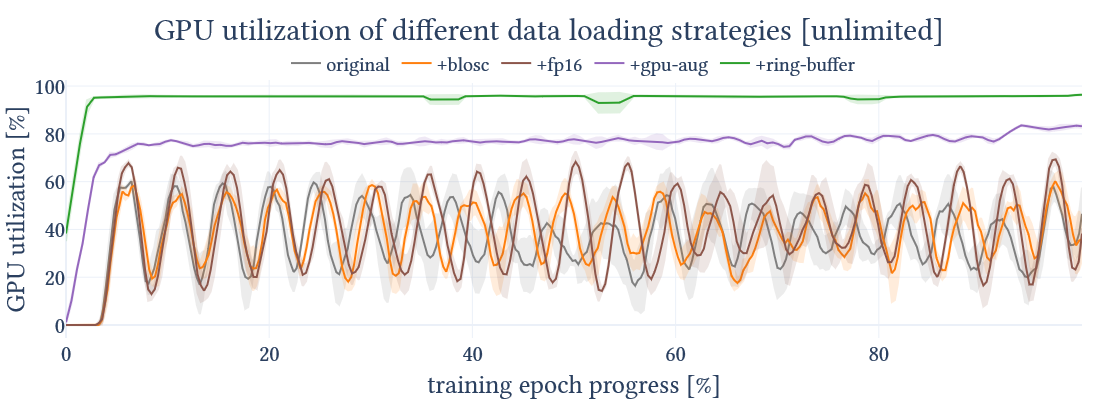

In [7]:
fig = go.Figure()

for i, row in df_bar.iterrows():
    if row["speed"] != "unlimited":
        continue

    y = row["epoch_utils_mean"]
    y_std = row["epoch_utils_std"]
    add_std_fill(
        fig,
        mid_line=y * 100,
        std_range=y_std * 100,
        x=np.linspace(0, 1, len(y)) * 100,
        linecolor=settings_bench.colors_dark[row["loading_strategy"]],
        label="+" + row["loading_strategy"] if row["loading_strategy"] != "original" else row["loading_strategy"],
    )

fig.update_yaxes(title="GPU utilization [%]")
fig.update_xaxes(title="training epoch progress [%]")
fig.update_layout(template="plotly_white", height=400, width=1000, margin=dict(l=0, r=0, t=80, b=0))
fig.update_layout(font_family="Libertinus Serif", font_size=22)
fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=0.99, xanchor="center", x=0.5, font=dict(size=20)))
fig.update_layout(title_x=0.5, title_text="GPU utilization of different data loading strategies [unlimited]")

fig.write_image(settings_bench.paper_dir / "utilization_loading_strategies.pdf")
fig.write_image(settings_bench.paper_dir / "utilization_loading_strategies.svg")
fig

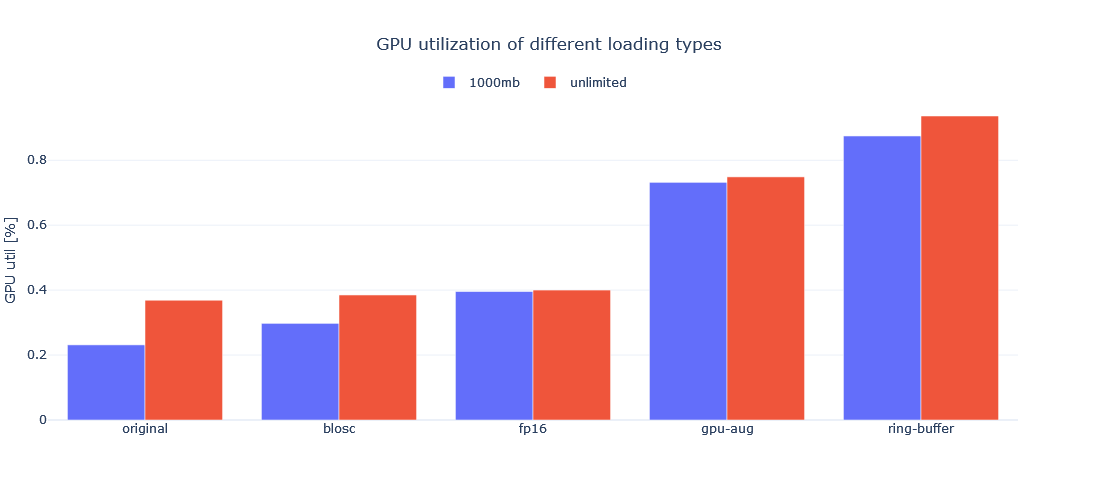

In [8]:
fig = go.Figure()

for speed in df_bar["speed"].unique():
    df_speed = df_bar.query("speed == @speed")
    fig.add_trace(go.Bar(name=speed, x=df_speed.loading_strategy, y=df_speed.gpu_util_mean))

fig.update_yaxes(title="GPU util [%]")
fig.update_layout(template="plotly_white", height=500, width=1100, margin=dict(l=0))
fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.01, xanchor="center", x=0.5, font=dict(size=12)))
fig.update_layout(title_x=0.5, title_text="GPU utilization of different loading types")